Entries Analysis
---

Author: Peter Zhang

Analysis of tournament entries.

### Setup

#### Imports

In [64]:
# imports
import csv
import mpu
import numpy as np
from matplotlib import pyplot as plt

#### Input Data

In [65]:
# location of the combined, entries dataset
ENTRIES_CSV = 'datasets/entries.csv'

In [66]:
# read entries
with open(ENTRIES_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    entries = [row for row in inReader]
    for entry in entries:
        entry['State'] = entry['State'].split("/")[0]

In [67]:
# location of the tournamnet info dataset
INFO_CSV = 'datasets/tournInfo.csv'

In [68]:
# read tournament info
tournInfo = {}
with open(INFO_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    for row in inReader:
        tournInfo[row["Tourn Name"]] = row
    for tourn in tournInfo:
        tournInfo[tourn]['State'] = tournInfo[tourn]['State'].split("/")[0]

In [69]:
# location of the state coordinates dataset
LOCATION_CSV = 'datasets/locations.csv'

In [70]:
# read locations as map
coordinates = {}
with open(LOCATION_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    for row in inReader:
        state = row['State']
        lat = float(row['Lattitude'])
        long = float(row['Longitude'])
        coordinates[state] = (lat, long)

In [71]:
# list of valid states
states = coordinates.keys()

In [72]:
# location of state abbreviations dataset
ABBREV_CSV = 'datasets/abbrev.csv'

In [73]:
# read abbreviations into map
abbrevOf = {}
with open(ABBREV_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    for row in inReader:
        abbrevOf[row['Name']] = row['Abbrev']

In [74]:
# state ACT scores dataset
ACT_CSV = 'datasets/actscores.csv'

In [75]:
# read ACT scores as map
acts = {}
with open(ACT_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    for row in inReader:
        state = row['State']
        if state in abbrevOf:
            acts[abbrevOf[state]] = float(row['Score'])

In [76]:
# real household income dataset
INCOME_CSV = 'datasets/income.csv'

In [77]:
# read income dataset as map
incomes = {}
with open(INCOME_CSV) as inFile:
    inReader = csv.DictReader(inFile)
    for row in inReader:
        state = row['State']
        if state in abbrevOf:
            income = row['Income'].replace(',', '')
            incomes[abbrevOf[state]] = int(income)

In [78]:
# result locations
TOURN_CSV = 'results/tournResults.csv'
STATES_CSV = 'results/stateResults.csv'
DATASETS_PATH = 'datasets/'

### Analysis

#### Helper Functions

In [79]:
# calculate average ACT score
def avgACT(entries):
    scores = [acts[entry['State']] for entry in entries if entry['State'] in states]
    return sum(scores)/len(scores)

In [80]:
# calculate average income
def avgIncome(entries):
    households = [incomes[entry['State']] for entry in entries if entry['State'] in states]
    return sum(households)/len(households)

In [81]:
# compute distance between two sets of coords
def distance(coords1, coords2):
    return mpu.haversine_distance(coords1, coords2)

In [82]:
# compute average distance of entries from host state
def avgDist(entries, host):
    hostCoords = coordinates[host]
    totalDist = 0
    for entry in entries:
        state = entry["State"]
        if state in states:
            coords = coordinates[state]
            totalDist += distance(hostCoords, coords)
    return totalDist/len(entries)

In [83]:
# collect tournament information
def getTournData(entries19, entries20, host):
    # count entries
    numEntries19 = len(entries19)
    numEntries20 = len(entries20)
    # get states
    states19 = set([entry["State"] for entry in entries19])
    states20 = set([entry["State"] for entry in entries20])
    # remove empty/unformatted states
    states19 = [state for state in states19 if state in states]
    states20 = [state for state in states20 if state in states]
    # find num of orig
    original = len([entry for entry in entries20 if entry["State"] in states19])
    # compute average distance, ACT, and income
    avgDist19 = avgDist(entries19, host)
    avgDist20 = avgDist(entries20, host)
    avgACT19 = avgACT(entries19)
    avgACT20 = avgACT(entries20)
    avgIncome19 = avgIncome(entries19)
    avgIncome20 = avgIncome(entries20)
    return [numEntries19,
            numEntries20,
           len(states19),
           len(states20),
           original, 
           avgDist19,
           avgDist20,
            avgACT19,
            avgACT20,
            avgIncome19,
            avgIncome20]

#### Example

In [84]:
# get dowling entries
dowling19 = [entry for entry in entries if entry["Tournament"] == "dowling19"]
dowling20 = [entry for entry in entries if entry["Tournament"] == "dowling20"]

In [85]:
# entries in 2019
len(dowling19)

264

In [86]:
# entries in 2020
len(dowling20)

292

In [87]:
# states in 2019
len(set([entry["State"] for entry in dowling19]))

15

In [88]:
# states in 2020
len(set([entry["State"] for entry in dowling20]))

29

In [89]:
# average distance
avgDist(dowling20, "IA")

776.879745918915

In [90]:
# tourn data
getTournData(dowling19, dowling20, "IA")

[264,
 292,
 15,
 28,
 232,
 418.315860380403,
 776.879745918915,
 21.853409090909167,
 22.263573883161577,
 70815.46212121213,
 72983.35738831614]

#### EDA

In [91]:
# get 2019 and 2020 entries
entries19 = [e for e in entries if e['Tournament'][-2:] == '19']
entries20 = [e for e in entries if e['Tournament'][-2:] == '20']

In [92]:
# distinct 2019 debaters
len(set([e['Name'] for e in entries19]))

5057

In [93]:
# distinct 2020 debaters
len(set([e['Name'] for e in entries20]))

5616

In [94]:
# entries per debater 2019
len(entries19)/5057

1.4987146529562982

In [95]:
# entries per debater 2020
len(entries20)/5679

1.7670364500792393

In [96]:
# percent increase
len(entries20)/len(entries19)

1.3240533051853807

#### Sig Test

Collect data to perform significance test in R.

In [119]:
# acts for each year
acts19 = [acts[e['State']] for e in entries19 if e['State'] in acts]
acts20 = [acts[e['State']] for e in entries20 if e['State'] in acts]

In [120]:
# write to output files
with open(DATASETS_PATH + 'acts19.txt', 'w') as out19, open(DATASETS_PATH + 'acts20.txt', 'w') as out20:
    [out19.write(str(a) + "\n") for a in acts19]
    [out20.write(str(a) + "\n") for a in acts20]

In [121]:
# incomes for each year
incomes19 = [incomes[e['State']] for e in entries19 if e['State'] in incomes]
incomes20 = [incomes[e['State']] for e in entries20 if e['State'] in incomes]

In [122]:
# write to output files
with open(DATASETS_PATH + 'incomes19.txt', 'w') as out19, open(DATASETS_PATH + 'incomes20.txt', 'w') as out20:
    [out19.write(str(a) + "\n") for a in incomes19]
    [out20.write(str(a) + "\n") for a in incomes20]

#### Tournament Analysis

In [101]:
# list of all tournaments
tourn_list = sorted(list(set([entry["Tournament"] for entry in entries])))
tourn_list[:5]

['UT19', 'UT20', 'alta19', 'alta20', 'applevalley19']

In [114]:
# tournament to entry map
entries_by_tourn = {}
for entry in entries:
    tourn = entry["Tournament"]
    if tourn in entries_by_tourn:
        entries_by_tourn[tourn].append(entry)
    else:
        entries_by_tourn[tourn] = [entry]

In [103]:
# write and collect tournament data
tournData = []
with open(TOURN_CSV, 'w') as outFile:
    outWriter = csv.writer(outFile, lineterminator = '\n')
    outWriter.writerow(["Tournament",
                        "Entries 2019",
                                           "Entries 2020",
                                           "States 2019",
                                           "States 2020",
                                           "Local 2020 Participants",
                                           "Avg Dist 2019",
                                           "Avg Dist 2020",
                                           "Avg ACT 2019",
                       "Avg ACT 2020",
                       "Avg Income 2019",
                       "Avg Income 2020"])
    for i in range(len(tourn_list)//2):
        tourn19 = tourn_list[2*i]
        tourn20 = tourn_list[2*i+1]
        host = tournInfo[tourn19]["State"]
        if host in abbrevOf:
            host = abbrevOf[host]
        datarow = [tourn19[:-2]] + getTournData(entries_by_tourn[tourn19],
                entries_by_tourn[tourn20],
                host)
        outWriter.writerow(datarow)
        tournData.append(datarow)

UT19
UT20
alta19
alta20
applevalley19
applevalley20
blake19
blake20
bluekey19
bluekey20
bronx19
bronx20
collegeprep19
collegeprep20
cypress19
cypress20
dowling19
dowling20
duke19
duke20
glenbrooks19
glenbrooks20
grapevine19
grapevine20
greenhill19
greenhill20
heritage19
heritage20
holycross19
holycross20
isidore19
isidore20
jackhowe19
jackhowe20
loyola19
loyola20
meadows19
meadows20
presentation19
presentation20
princeton19
princeton20
ridge19
ridge20
seattle19
seattle20
strake19
strake20
uk19
uk20
usc19
usc20
valley19
valley20
yale19
yale20


In [110]:
tournData[-4]

['uk',
 297,
 764,
 24,
 33,
 657,
 897.4417380904232,
 1260.0560472266932,
 21.348797250859104,
 22.121810699588497,
 67896.47766323024,
 74294.08916323731]

#### Visualizations

In [111]:
# changes in entry, sorted increasing
changeData = [[d[0], d[2]-d[1]] for d in tournData]
changeData.sort(key=lambda x: x[1])

In [112]:
# name corrections, if necessary
fixName = {
    "heritage" : "JW Patterson",
    "usc" : "USC",
    "UT" : "UT",
    "bluekey" : "Blue Key",
    "cypress" : "Cypress Bay",
    'collegeprep' : "College Prep",
    'applevalley' : "Apple Valley",
    'holycross' : "Holy Cross",
    "jackhowe" : "Jack Howe",
    'uk': "UK"
}

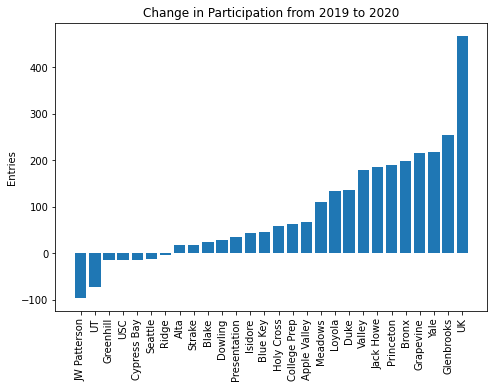

In [113]:
# plot of changes in participation
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([fixName[d[0]] if d[0] in fixName else d[0].title() for d in changeData], [d[1] for d in changeData])
plt.title("Change in Participation from 2019 to 2020")
plt.ylabel("Entries")
plt.xticks(rotation='vertical')
plt.show()

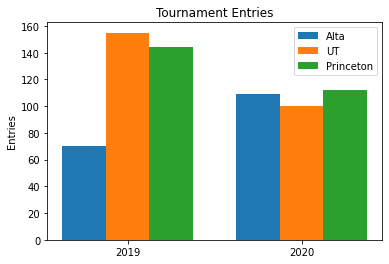

In [486]:
# alta/ut/princeton visualization
N = 2
alta = (70, 109)
ut = (155, 100)
princeton = (144, 112)

ind = np.arange(N) 
width = 0.25    
plt.bar(ind, alta, width, label='Alta')
plt.bar(ind + width, ut, width,
    label='UT')
plt.bar(ind + 2*width, princeton, width,
    label='Princeton')

plt.ylabel('Entries')
plt.title('Tournament Entries')

plt.xticks(ind + width, ('2019', '2020'))
plt.legend(loc='best')
plt.show()

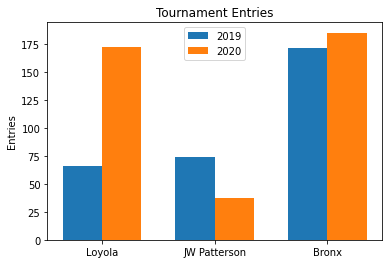

In [116]:
# loyola/heritage/bronx visualization
N = 3
data19 = (66, 74, 171)
data20 = (172, 37, 185)

ind = np.arange(N) 
width = 0.35    
plt.bar(ind, data19, width, label='2019')
plt.bar(ind + width, data20, width,
    label='2020')

plt.ylabel('Entries')
plt.title('Tournament Entries')

plt.xticks(ind + width/2, ('Loyola', 'JW Patterson', "Bronx"))
plt.legend(loc='best')
plt.show()

In [117]:
# act data, sorted
actData = [[d[0], d[8], d[9]] for d in tournData]
actData.sort(key=lambda x: x[1])

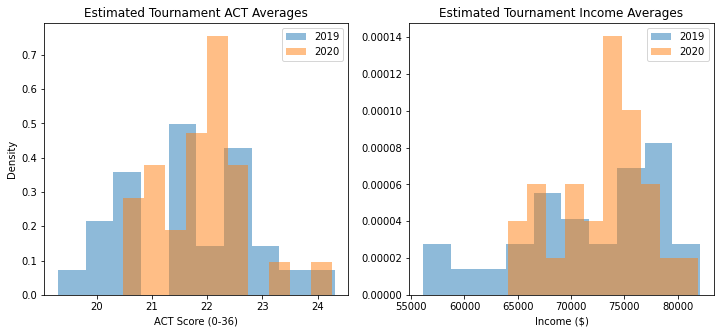

In [118]:
# plots of ACT and income tournament averages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.hist([d[8] for d in tournData], alpha=0.5, label='2019', density=True)
ax1.hist([d[9] for d in tournData], alpha=0.5, label='2020', density=True)
#plt.xticks(range(1, 21))
ax1.set(xlabel="ACT Score (0-36)", ylabel="Density")
ax1.set_title("Estimated Tournament ACT Averages")
ax1.legend(loc='upper right')
ax2.hist([d[10] for d in tournData], alpha=0.5, label='2019', density=True)
ax2.hist([d[11] for d in tournData], alpha=0.5, label='2020', density=True)
#plt.xticks(range(1, 21))
ax2.set(xlabel="Income ($)")
ax2.set_title("Estimated Tournament Income Averages")
ax2.legend(loc='upper right')

#### State Analysis

In [162]:
# count entries in each state
state_entries19 = dict([[state, 0] for state in states])
state_entries20 = dict([[state, 0] for state in states])
for entry in entries:
    state = entry['State']
    if state in states:
        if "19" in entry['Tournament']:
            state_entries19[state] += 1
        else:
            state_entries20[state] += 1

In [163]:
# aggregate distance by state
state_distance19 = dict([[state, 0] for state in states])
state_distance20 = dict([[state, 0] for state in states])
for entry in entries:
    state = entry['State']
    host = tournInfo[entry['Tournament'][:-2] + "19"]['State']
    if host in abbrevOf:
        host = abbrevOf[host]
    if state in states:
        if "19" in entry['Tournament']:
            state_distance19[state] += distance(coordinates[state], coordinates[host])
        else:
            state_distance20[state] += distance(coordinates[state], coordinates[host])

In [164]:
# convert to average
for state in states:
    if state_entries19[state] > 0:
        state_distance19[state] /= state_entries19[state]
    if state_entries20[state] > 0:
        state_distance20[state] /= state_entries20[state]

In [165]:
# write to result file
with open(STATES_CSV, 'w') as outFile:
    outWriter = csv.writer(outFile, lineterminator = '\n')
    outWriter.writerow(["State",
                      "Entries19",
                      "Entries20",
                      "Distance19",
                      "Distance20"])
    for state in states:
        outWriter.writerow([state,
                           state_entries19[state],
                           state_entries20[state],
                           state_distance19[state],
                           state_distance20[state]])

#### State Visualizations

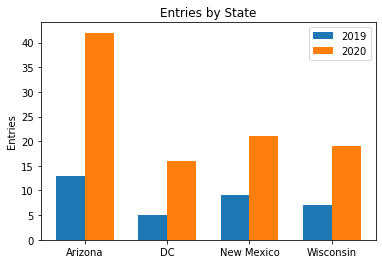

In [101]:
# entries by state visualization
N = 4
data19 = (13, 5, 9, 7)
data20 = (42, 16, 21, 19)

ind = np.arange(N) 
width = 0.35    
plt.bar(ind, data19, width, label='2019')
plt.bar(ind + width, data20, width,
    label='2020')

plt.ylabel('Entries')
plt.title('Entries by State')

plt.xticks(ind + width/2, ('Arizona', 'DC', 'New Mexico', 'Wisconsin'))
plt.legend(loc='best')
plt.show()

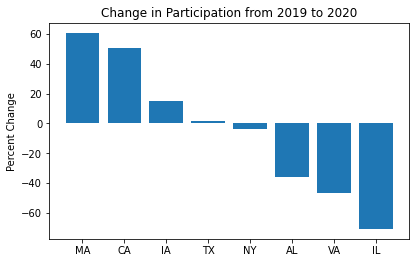

In [102]:
# example states plot (omitted from article)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
labels = ["MA", "CA", "IA", "TX", "NY","AL",  "VA", "IL"]
values = [60.86, 50.68, 15.07, 1.81, -3.72, -35.71, -47.06, -70.91]
ax.bar(labels, values)
plt.title("Change in Participation from 2019 to 2020")
plt.ylabel("Percent Change")
plt.show()

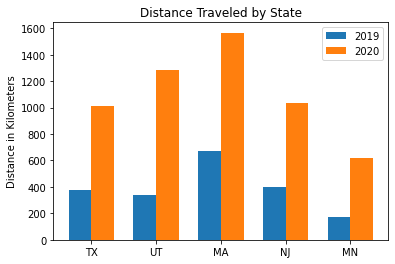

In [103]:
# distance traveled by state
N = 5
data19 = (378, 337, 671, 400, 173)
data20 = (1009, 1287, 1566, 1032, 621)

ind = np.arange(N) 
width = 0.35    
plt.bar(ind, data19, width, label='2019')
plt.bar(ind + width, data20, width,
    label='2020')

plt.ylabel('Distance in Kilometers')
plt.title('Distance Traveled by State')

plt.xticks(ind + width/2, ('TX', 'UT', 'MA', 'NJ', 'MN'))
plt.legend(loc='best')
plt.show()

#### Lone Wolves

In [166]:
# school sizes
teammembers19 = {}
for entry in entries19:
    if not entry['School'] in teammembers19:
        teammembers19[entry['School']] = set()
    teammembers19[entry['School']].add(entry['Name'])
teammembers20 = {}
for entry in entries20:
    if not entry['School'] in teammembers20:
        teammembers20[entry['School']] = set()
    teammembers20[entry['School']].add(entry['Name'])

In [167]:
# average team size 2019
sum([len(t) for t in teammembers19.values()])/len(teammembers19)

4.188405797101449

In [168]:
# average team size 2020
sum([len(t) for t in teammembers20.values()])/len(teammembers20)

2.8633093525179856

In [169]:
# get school sizes, and new entries (omitted from article)
schoolNew = {}
schoolAll = {}
loneWolves = {}
LW19 = 0
LW20 = 0
sizes19 = []
sizes20 = []
for i in range(len(tourn_list)//2):
    tourn19 = tourn_list[2*i]
    tourn20 = tourn_list[2*i+1]
    entries19 = entries_by_tourn[tourn19]
    entries20 = entries_by_tourn[tourn20]
    oldSchools = [entry['School'] for entry in entries19]
    schoolSizes = {}
    for entry in entries19:
        school = entry['School']
        if school in schoolSizes:
            schoolSizes[school] += 1
        else:
            schoolSizes[school] = 1
    print(tourn19)
    print(sum(schoolSizes.values())/len(schoolSizes))
    sizes19 += list(schoolSizes.values())
    for school in schoolSizes:
        if schoolSizes[school] == 1:
            LW19 += 1
    
    schoolSizes = {}
    for entry in entries20:
        school = entry['School']
        
        if school in schoolSizes:
            schoolSizes[school] += 1
        else:
            schoolSizes[school] = 1
        
        if school in schoolAll:
            schoolAll[school] += 1
        else:
            schoolAll[school] = 1
        
        if school not in oldSchools:
            if school in schoolNew:
                schoolNew[school] += 1
            else:
                schoolNew[school] = 1
        
    print(tourn20)
    print(sum(schoolSizes.values())/len(schoolSizes))
    for school in schoolSizes:
        if schoolSizes[school] == 1:
            LW20 += 1
    sizes20 += list(schoolSizes.values())

UT19
4.228915662650603
UT20
3.875
alta19
2.8518518518518516
alta20
2.361904761904762
applevalley19
4.587628865979381
applevalley20
3.657142857142857
blake19
3.3559322033898304
blake20
2.8066666666666666
bluekey19
3.876543209876543
bluekey20
2.699248120300752
bronx19
3.485074626865672
bronx20
3.2807881773399017
collegeprep19
3.0
collegeprep20
2.8208955223880596
cypress19
3.914285714285714
cypress20
2.5625
dowling19
3.8260869565217392
dowling20
2.891089108910891
duke19
4.71875
duke20
3.142857142857143
glenbrooks19
3.2747252747252746
glenbrooks20
4.004716981132075
grapevine19
3.0697674418604652
grapevine20
3.0573248407643314
greenhill19
2.212121212121212
greenhill20
2.04
heritage19
3.9672131147540983
heritage20
2.4098360655737703
holycross19
2.888888888888889
holycross20
2.4285714285714284
isidore19
3.3653846153846154
isidore20
2.460674157303371
jackhowe19
4.658730158730159
jackhowe20
3.7524271844660193
loyola19
2.0
loyola20
2.2613636363636362
meadows19
2.1555555555555554
meadows20
3.1846

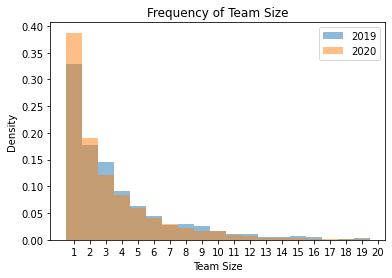

In [170]:
# plot squad sizes
plt.hist(sizes19, bins=[x-0.5 for x in range(1, 21)], alpha=0.5, label='2019', density=True)
plt.hist(sizes20, bins=[x-0.5 for x in range(1, 21)], alpha=0.5, label='2020', density=True)
plt.xticks(range(1, 21))
plt.xlabel("Team Size")
plt.ylabel("Density")
plt.title("Frequency of Team Size")
plt.legend(loc='upper right')

In [171]:
# percent lone wolves in 2019
LW19/2599

0.25971527510580994

In [172]:
# percent lone wolves 2020
LW20/3054

0.3975114603798297

### Cross-Event

In [149]:
for event in ["LD", "PF", "CX"]:
    for division in ["V", "JV", "N"]:
        entries2019 = len([e for e in entries if e["Event"] == division+event and e["Tournament"][-2:] == "19"])
        entries2020 = len([e for e in entries if e["Event"] == division+event and e["Tournament"][-2:] == "20"])
        print(division, event)
        print(entries2019)
        print(entries2020)

V LD
2599
3054
JV LD
285
592
N LD
416
379
V PF
2489
3057
JV PF
104
571
N PF
289
555
V CX
1270
1322
JV CX
11
211
N CX
116
294


In [147]:
event_div_increase

[[1.1750673335898423, 2.07719298245614, 0.9110576923076923],
 [1.2282040980313378, 5.490384615384615, 1.9204152249134947],
 [1.0409448818897638, 19.181818181818183, 2.5344827586206895]]

In [159]:
new = 0
lost = 0
newJV = 0
for i in range(len(tourn_list)//2):
    tourn19 = tourn_list[2*i]
    tourn20 = tourn_list[2*i+1]
    entries19 = entries_by_tourn[tourn19]
    entries20 = entries_by_tourn[tourn20]
    events19 = set(e['Event'] for e in entries19)
    events20 = set(e['Event'] for e in entries20)
    for event in events20:
        if event not in events19:
            print(tourn20, "added", event)
            new+=1
            if event[:2] == "JV":
                newJV+=1
    for event in events19:
        if event not in events20:
            print(tourn20, "lost", event)
            lost+=1

UT20 added NCX
UT20 added NPF
UT20 added NLD
blake20 added NCX
bluekey20 added NPF
bluekey20 added NLD
bronx20 added JVPF
bronx20 added JVLD
bronx20 added JVCX
collegeprep20 added JVLD
cypress20 added JVPF
dowling20 added NLD
duke20 added JVPF
duke20 added JVLD
duke20 lost NPF
duke20 lost NLD
glenbrooks20 added NCX
glenbrooks20 added JVCX
grapevine20 added JVPF
grapevine20 added JVLD
grapevine20 added JVCX
heritage20 added JVCX
heritage20 lost VPF
heritage20 lost NPF
heritage20 lost NLD
holycross20 added VCX
holycross20 lost NCX
jackhowe20 added JVCX
loyola20 added VPF
meadows20 added JVLD
meadows20 added NCX
meadows20 added JVCX
meadows20 added NLD
princeton20 added JVPF
princeton20 added JVLD
princeton20 added NPF
ridge20 added NCX
seattle20 added JVPF
seattle20 lost NCX
uk20 added JVLD
uk20 added NCX
uk20 added NPF
uk20 added JVCX
usc20 added NCX
usc20 added JVCX
yale20 added JVCX


In [160]:
print(new, lost, newJV)

39 7 22


In [158]:
[e for e in entries_by_tourn['holycross19'] if e['Event'] == 'NCX']

[OrderedDict([('Tournament', 'holycross19'),
              ('Event', 'NCX'),
              ('School', 'Baton Rouge High School'),
              ('State', 'LA'),
              ('Name', 'Parker & Li'),
              ('Code', 'Baton Rouge PL'),
              ('Status', None)]),
 OrderedDict([('Tournament', 'holycross19'),
              ('Event', 'NCX'),
              ('School', 'Isidore Newman School'),
              ('State', 'LA'),
              ('Name', 'Elliot & Piedimonte'),
              ('Code', 'Isidore Newman EP'),
              ('Status', None)]),
 OrderedDict([('Tournament', 'holycross19'),
              ('Event', 'NCX'),
              ('School', 'Neville High School'),
              ('State', 'LA'),
              ('Name', 'Haynes & Merritt'),
              ('Code', 'Neville HaMe'),
              ('Status', None)]),
 OrderedDict([('Tournament', 'holycross19'),
              ('Event', 'NCX'),
              ('School', 'Neville High School'),
              ('State', 'LA'),
       